# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.weightstats as ws

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


We will use a two sample z test to determine if there is a difference between the number of callbacks between 'white' and 'black' applicants. Since there are more than 30 sampled applicants for each race, we can use a z-test to determine if there is a difference between the two samples. 

In [5]:
def draw_bs_samples(data, func, size=1):
    replicates = np.empty(size)
    len_data = len(data)
    for i in range(size):
        sample_temps = np.random.choice(data, len_data)
        replicates[i] = func(sample_temps)
        
    return replicates


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


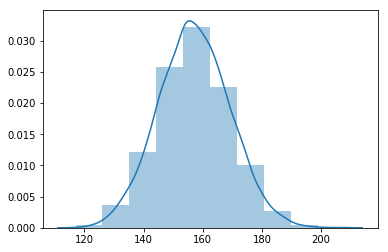

In [6]:
b_applicants = data[data.race == 'b']
bs_b_applicant = draw_bs_samples(b_applicants.call, np.sum, 10000)

_ = sns.distplot(bs_b_applicant, hist=True, bins=10)

In [7]:
p_b = stats.normaltest(bs_b_applicant)

p_b

NormaltestResult(statistic=10.156676939523818, pvalue=0.006230252173205497)

In [8]:
if(p_b.pvalue <= 0.05):
    print("Not normal distribution, p-value of ", p_b.pvalue)
else:
    print('Fail to prove its not a normal distribution, p-value of ', p_b.pvalue)

Not normal distribution, p-value of  0.006230252173205497


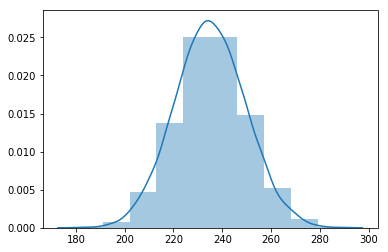

In [9]:
w_applicants = data[data.race == 'w']
bs_w_applicant = draw_bs_samples(w_applicants.call, np.sum, 10000)

_ = sns.distplot(bs_w_applicant, hist=True, bins=10)

In [10]:
p_w = stats.normaltest(bs_w_applicant)

p_w

NormaltestResult(statistic=1.700824824215173, pvalue=0.427238697198998)

In [11]:
if(p_w.pvalue <= 0.05):
    print("Not normal distribution, p-value of ", p_w.pvalue)
else:
    print('Fail to prove its not a normal distribution, p-value of ', p_w.pvalue)

Fail to prove its not a normal distribution, p-value of  0.427238697198998


Since we failed to prove that this data is not normal, we can proceed as if it is. 


Our null hypothesis is there no difference between the number or responses for white and black applicants.

Our alternative hypothesis is that there is a difference between the number of responses between white and black applicants. 

In [12]:
w = data[data.race=='w']
b = data[data.race=='b']

   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

First I will use the bootstrap approach!

In [13]:
#MARGIN OF ERROR FOR BLACK APPLICANTS

# alpha (α): α = 1 - 0.05/2
# crit value = z -> .975
crit_value_b = stats.norm.ppf(1 - (.05/2))
# Standard Error = sd / sqrt( n ) 
stand_err_b = bs_b_applicant.std() / np.sqrt(len(bs_b_applicant))
# ME = Critical value x Standard error
margin_error_b = crit_value_b * stand_err_b

print('margin of error for black applicants is', margin_error_b,' when our alpha is 0.05')

margin of error for black applicants is 0.23688277277136263  when our alpha is 0.05


In [14]:
#CONFIDENCE INTERVAL FOR BLACK APPLICANTS
confidence_int_b = np.percentile(bs_b_applicant, [2.5, 97.5])
print('the 95% confidence interval for black applicants will fall between', confidence_int_b[0], 'and', confidence_int_b[1])

the 95% confidence interval for black applicants will fall between 134.0 and 181.0


In [15]:
#MARGIN OF ERROR FOR WHITE APPLICANTS

# alpha (α): α = 1 - 0.05/2
# crit value = z -> .975
crit_value_w = stats.norm.ppf(1 - (.05/2))
# Standard Error = sd / sqrt( n ) 
stand_err_w = bs_w_applicant.std() / np.sqrt(len(bs_w_applicant))
# ME = Critical value x Standard error
margin_error_w = crit_value_w * stand_err_w

print('margin of error for white applicants is', margin_error_w,' when our alpha is 0.05')

margin of error for white applicants is 0.2855297068992585  when our alpha is 0.05


In [16]:
#CONFIDENCE INTERVAL FOR WHITE APPLICANTS
confidence_int_w = np.percentile(bs_w_applicant, [2.5, 97.5])
print('the 95% confidence interval for white applicants will fall between', confidence_int_w[0], 'and', confidence_int_w[1])

the 95% confidence interval for white applicants will fall between 207.0 and 264.0


we will use a two sample z test to check our hypothesis.

In [17]:
b_mean = np.mean(bs_b_applicant)
w_mean = np.mean(bs_w_applicant)
off = b_mean - w_mean
off

-77.8914

In [18]:
(diff_z, diff_p_z) = ws.ztest(bs_b_applicant, bs_w_applicant, value=off )
(diff_z, diff_p_z)

(0.0, 1.0)

Now we will use the frequentist approach to find the same information. We will use the number of calls an applicant expects to get, in terms of a fraction.

In [23]:
b_call_mean = np.mean(b.call)
b_call_std = np.std(b.call)
print(b_call_mean, b_call_std)


0.0644763857126236 0.24559901654720306


In [25]:
w_call_mean = np.mean(w.call)
w_call_std = np.std(w.call)
print(w_call_mean, w_call_std)


0.09650924056768417 0.29528486728668213


In [28]:
(diff_z, diff_p_z) = ws.ztest(b.call, w.call, value=0 )
(diff_z, diff_p_z)

(-4.114705356750735, 3.8767429116085706e-05)

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>